In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import os
import zipfile
import requests

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"Using device: {device}")

if device.type == 'cuda':
    devNumber=torch.cuda.current_device()
    print(f"Current Device Number: {devNumber}")

    devName=torch.cuda.get_device_name(devNumber)
    print(f"Device Name: {devName}")


Using device: cuda
Current Device Number: 0
Device Name: NVIDIA GeForce RTX 3060


### Download Playing Cards Dataset (Around 500mb)

In [3]:
DATA_DIR = "data"
ZIP_PATH = "data/cards.zip"

# Train data directory
data_dir= "data/train"

# Create folder
os.makedirs(DATA_DIR, exist_ok=True)

print("Downloading dataset...")
response = requests.get("https://www.kaggle.com/api/v1/datasets/download/gpiosenka/cards-image-datasetclassification", stream=True)

# Save zip file
with open(ZIP_PATH, "wb") as f:
        for chunk in tqdm(response.iter_content(chunk_size=8192), desc="Downloading", unit="kb"):
            f.write(chunk)

# Extract zip file
print("Extracting dataset...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

# Remove zip file
os.remove(ZIP_PATH)

print("Dataset ready!")

Downloading: 49301kb [00:20, 2449.53kb/s]


Extracting dataset...
Dataset ready!


### Print version numbers

In [4]:
print("System Version:", sys.version)
print("PyTorch Version:", torch.__version__)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("Torchvision Version:", torchvision.__version__)
print("Timm Version:", timm.__version__)


System Version: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
PyTorch Version: 2.9.1+cu130
NumPy Version: 2.2.1
Pandas Version: 2.3.3
Torchvision Version: 0.24.1+cpu
Timm Version: 1.0.22


# Step 1: Creating a PyTorch Dataset

In [5]:
class PlayingCardDataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [6]:
dataset = PlayingCardDataSet(data_dir)


In [7]:
len(dataset)

7624

34


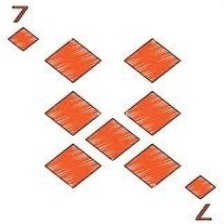

In [8]:
image, label = dataset[5000]
print(label)
image

In [9]:
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = PlayingCardDataSet(data_dir, transform)

In [11]:
for images, labels in dataset:
    break

## Dataloader

In [12]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for images, labels in dataloader:
    break

In [13]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [14]:
labels

tensor([44, 12, 14, 34, 25, 45, 43, 41, 16,  9, 18,  5, 21, 12,  3, 22,  7, 14,
        46, 13, 25, 18, 52, 39, 31, 36, 44,  8, 50,  2, 21, 38])

# Step 2: PyTorch Model

In [15]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Linear(enet_out_size, num_classes)


    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [16]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [17]:
example_out = model(images)
example_out.shape # [Batch size, num_classes]

torch.Size([32, 53])

# Step 3: Training Loop

In [18]:
# Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
criterion(example_out, labels)

tensor(4.0427, grad_fn=<NllLossBackward0>)

In [20]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = "data/train"
valid_folder = "data/valid"
test_folder = "data/test"

train_dataset = PlayingCardDataSet(train_folder, transform=transform)
valid_dataset = PlayingCardDataSet(valid_folder, transform=transform)
test_dataset = PlayingCardDataSet(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Training loop

In [21]:
num_epochs = 5
train_losses, val_losses= [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training Loader"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation Loader"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}')




Validation Loader: 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


Epoch [1/5], Train Loss: 1.5250066009673593, Val Loss: 0.5506118392044643


Validation Loader: 100%|██████████| 9/9 [00:00<00:00, 23.63it/s]


Epoch [2/5], Train Loss: 0.5509017086729548, Val Loss: 0.3281382443769923


Validation Loader: 100%|██████████| 9/9 [00:00<00:00, 22.66it/s]


Epoch [3/5], Train Loss: 0.3201691311982471, Val Loss: 0.1864711511809871


Validation Loader: 100%|██████████| 9/9 [00:00<00:00, 17.18it/s]


Epoch [4/5], Train Loss: 0.25040032741968427, Val Loss: 0.1477084918404525


Validation Loader: 100%|██████████| 9/9 [00:00<00:00, 23.40it/s]

Epoch [5/5], Train Loss: 0.18577958874068254, Val Loss: 0.24897843441873227


# Visualize training and validation loss

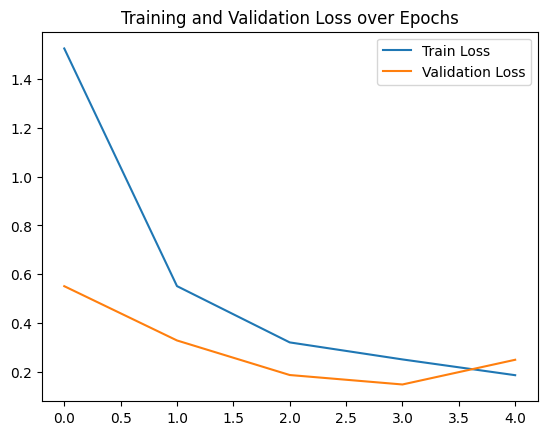

In [22]:
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

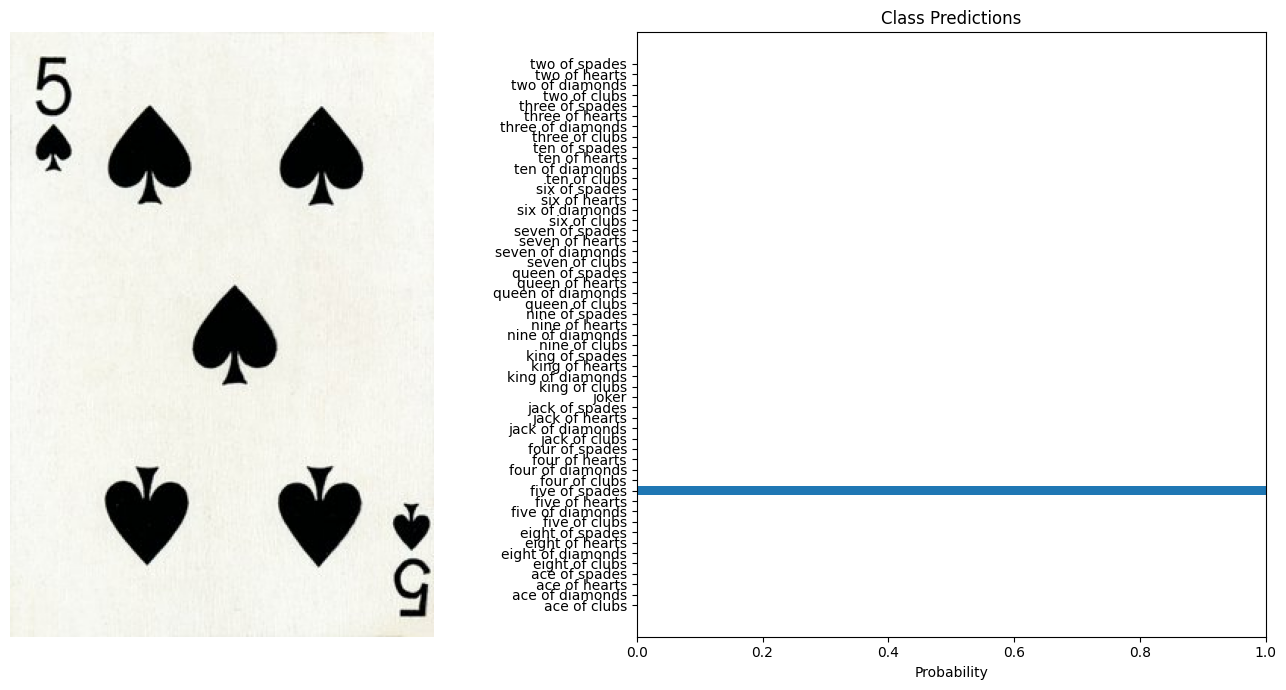

In [23]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "5_of_spades.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)